# Unit 5 - Financial Planning

In [73]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [74]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [75]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [76]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

btc_url = btc_url + "?format=json"
eth_url = eth_url + "?format=json"

In [77]:
# Fetch current BTC price
btc_price_reqeust = requests.get(btc_url)
btc_price_reqeust_content = btc_price_reqeust.content
#print(btc_price_reqeust_content)
import json
btc_data = btc_price_reqeust.json()
#print(json.dumps(btc_data, indent=4))
btc_price = btc_data['data']['1']['quotes']['USD']['price']
#print(btc_price)

# Fetch current ETH price
eth_price_request = requests.get(eth_url)
eth_price_request_content = eth_price_request.content
eth_data = eth_price_request.json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']


# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $20270.52
The current value of your 5.3 ETH is $6765.24


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [78]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [79]:
# Set Alpaca API key and secret
API_KEY = os.getenv('ALPACA_API_KEY')

API_SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')

type(API_KEY)

# Create the Alpaca API object
alpaca = tradeapi.REST(
    API_KEY,
    API_SECRET_KEY,
    api_version='v2'
)

In [80]:
# Format current date as ISO format
today = pd.Timestamp("2020-11-11", tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start=today,
    end=today
).df

df_portfolio.head()

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG']
SPY = df_portfolio[df_portfolio['symbol']=='SPY']

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG,SPY], axis=1, keys=["AGG", "SPY"])

# Preview DataFrame
df_portfolio

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2020-11-11 05:00:00+00:00  117.06  117.18  117.02  117.13  3044345   

                                                            SPY          \
                          trade_count        vwap symbol   open    high   
timestamp                                                                 
2020-11-11 05:00:00+00:00       12464  117.090607    AGG  356.4  357.56   

                                                                             \
                              low   close    volume trade_count        vwap   
timestamp                                                                     
2020-11-11 05:00:00+00:00  355.06  356.72  58649048      319238  356.272183   

                                  
                          symbol  
timestamp                         
2020-11-11 05:00:00+00:00    SPY

In [81]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio['AGG']['close'])
spy_close_price = float(df_portfolio['SPY']['close'])
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $117.13
Current SPY closing price: $356.72


In [82]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $17836.00
The current value of your 200 AGG shares is $23426.00


### Savings Health Analysis

In [83]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
total_crypto = my_btc_value + my_eth_value
total_shares = my_agg_value + my_spy_value

# Create savings DataFrame
savings_data = {
    "Amount": [total_crypto,total_shares]
}

df_savings = pd.DataFrame(savings_data, index=['crypto','shares'])

# Display savings DataFrame
display(df_savings)

,Amount
crypto,27035.758
shares,41262.000


array([<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>],
      dtype=object)

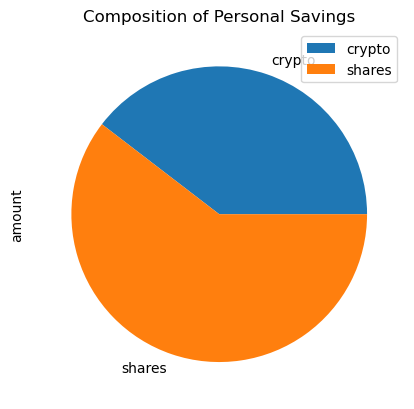

In [84]:
# Plot savings pie chart
df_savings.plot.pie(title={'Composition of Personal Savings'}, ylabel='amount',subplots=True)


In [85]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3
#display(emergency_fund)
# Calculate total amount of savings
total_savings = total_crypto + total_shares
#display(total_savings)
# Validate saving health
if emergency_fund < total_savings:
    print(f"you are secure")
if emergency_fund == total_savings:
    print(f"you need a little more savings")
if emergency_fund > total_savings:
    print(f"you need to get a second job. you are ${emergency_fund - total_savings} away from your goal")

you are secure


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [86]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [87]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ['AGG', 'SPY']

df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df



# Reorganize the DataFrame
# Separate ticker data
agg = df_stock_data[df_stock_data['symbol']== "AGG"]
spy = df_stock_data[df_stock_data['symbol']== "SPY"]

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg,spy], axis= 1, keys= ['AGG','SPY']) 

# Display sample data
df_stock_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                             SPY          \
                          trade_count        vwap symbol    open    high   
timestamp                                                                  
2016-05-02 04:00:00+00:00       15119  110.627199    AGG  206.92  208.18   
2016-05-03 04:00:00+00:00       15662  110.865995    AGG  206.52  206.80   
2016-05-04 04:00:00+00:00       13982  110.879063    AGG  204.99  205.85   
2016-05-05 04:00:00+00:00       15707  111.028363    AGG  205.56  205.98   
2016-05-06 04:00:00+00:00       12697  111.031967    AGG  204.08  205.77   

                                                                    \
                              low     close     volume trade_count   
timestamp                                                            
2016-05-02 04:00:00+00:00  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  203.88  205.7200   89131004      340335   

                                              
                                 vwap symbol  
timestamp                                     
2016-05-02 04:00:00+00:00  207.294812    SPY  
2016-05-03 04:00:00+00:00  206.312060    SPY  
2016-05-04 04:00:00+00:00  205.090172    SPY  
2016-05-05 04:00:00+00:00  205.141555    SPY  
2016-05-06 04:00:00+00:00  204.937074    SPY

In [88]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_60_40_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.40,0.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [89]:
# Printing the simulation input data
MC_60_40_dist.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                          SPY  \
                          trade_count        vwap symbol daily_return    open   
timestamp                                                                       
2016-05-02 04:00:00+00:00       15119  110.627199    AGG          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995    AGG     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063    AGG     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363    AGG     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    AGG    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                           
                                 vwap symbol daily_return  
timestamp                                                  
2016-05-02 04:00:00+00:00  207.294812    SPY          NaN  
2016-05-03 04:00:00+00:00  206.312060    SPY    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    SPY    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    SPY    -0.000195  
2016-05-06 04:00:00+00:00  204.937074    SPY     0.003659

In [90]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_60_40_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998728,0.998042,0.996322,0.995049,0.990841,0.999357,1.004846,1.000568,0.998470,1.000940,...,0.995323,0.992308,1.010135,1.002857,1.006045,0.993195,1.009732,0.995329,1.007863,0.995986
2,1.003151,0.991795,1.004388,0.989629,0.979663,1.005453,0.996959,1.014316,1.001584,0.998419,...,1.005334,1.000640,1.023482,1.009529,1.002771,0.988213,1.011681,0.986780,1.007913,0.992691
3,1.007530,0.999513,1.008721,0.991967,0.985023,0.992587,0.993950,1.023439,1.007758,0.995031,...,1.007543,0.995368,1.022576,0.998692,1.004122,0.985738,1.021743,0.988782,1.002109,0.989876
4,1.017980,0.993409,0.992998,0.997690,0.993929,0.992316,0.993345,1.016257,1.008652,0.991155,...,1.018645,0.994952,1.035091,0.994941,1.020775,0.988795,1.018142,0.979790,1.001266,0.989263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,16.322514,30.043211,9.149974,33.462926,8.872510,11.164007,13.792884,8.563118,4.438583,17.953166,...,13.807514,3.037540,19.603921,17.397498,14.176536,17.186492,44.208810,12.697171,8.097971,12.556125
7557,16.258928,29.990564,9.064711,33.335920,8.960644,11.200611,13.773810,8.543011,4.478708,18.031445,...,13.494765,3.054735,19.682126,17.307268,14.266511,17.199712,44.315799,12.919138,8.191308,12.411169
7558,16.150700,29.912118,9.038894,33.289218,8.946304,11.038032,13.703704,8.549309,4.444501,18.077755,...,13.412244,3.021370,19.788038,17.431665,14.285245,17.208856,44.073950,12.972353,8.190494,12.376874
7559,16.343743,30.032748,9.072947,33.224008,8.932136,11.183066,13.718374,8.512121,4.496905,18.148275,...,13.476437,3.045013,19.678503,17.366356,14.416221,17.184152,43.798952,12.929388,8.102965,12.302615


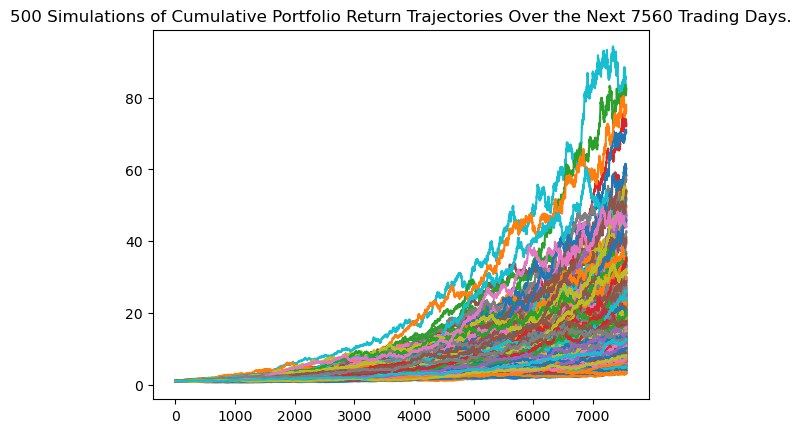

In [91]:
# Plot simulation outcomes
line_plot = MC_60_40_dist.plot_simulation()


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

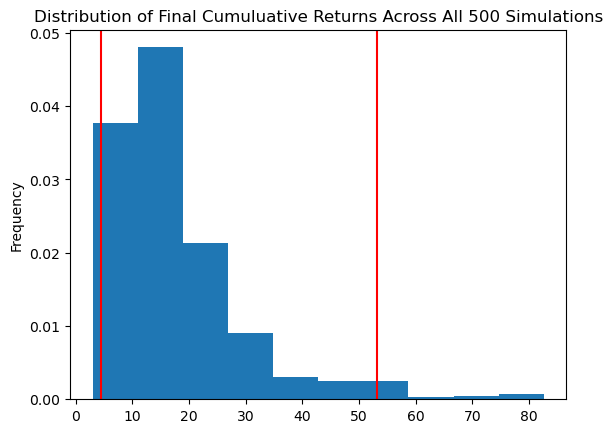

In [92]:
# Plot probability distribution and confidence intervals
MC_60_40_dist.plot_distribution()


### Retirement Analysis

In [93]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_60_40_dist.summarize_cumulative_return()

# Print summary statistics
print(tbl)


count           500.000000
mean             17.827044
std              12.195378
min               3.020419
25%              10.005172
50%              14.524517
75%              21.812499
max              82.577855
95% CI Lower      4.501054
95% CI Upper     53.199285
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [94]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $90021.07 and $1063985.7


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [95]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $135031.61 and $1595978.55


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [96]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_60_40_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.40,0.60],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [97]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_60_40_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.010832,0.995878,1.003497,1.009613,0.995997,1.006129,0.999465,1.003658,1.002833,0.997911,...,1.012889,0.995170,0.999535,0.999643,0.993151,1.002601,0.987788,0.989821,0.997124,0.990382
2,1.002590,1.006643,0.989941,1.004411,1.002086,1.013685,1.000219,0.993719,1.009563,0.992307,...,1.019652,0.989287,0.991938,0.999038,0.989881,0.991508,0.985321,0.995654,0.989255,0.996177
3,0.993170,1.024410,0.995973,1.007061,1.012078,1.019870,1.000385,0.991843,1.002475,0.984816,...,1.021792,0.989514,0.992469,0.993309,0.994451,0.986514,0.974782,0.991694,1.003961,0.994370
4,0.986596,1.039457,0.975001,1.009551,1.013278,1.024039,0.997237,1.000261,0.992621,0.990720,...,1.028005,1.003435,0.978128,0.992305,1.008531,0.979163,0.975285,0.996816,0.987358,0.989617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.440857,2.056560,1.061595,2.213131,1.473003,1.447306,2.332848,1.270520,1.092169,1.144526,...,2.053446,1.020554,1.190432,2.518635,1.655708,1.071233,1.738119,1.604119,1.309825,1.537977
1257,1.424890,2.035189,1.059612,2.223345,1.472532,1.442294,2.378007,1.261091,1.099511,1.146793,...,2.043948,1.021446,1.203857,2.499342,1.653673,1.061391,1.730201,1.611155,1.313497,1.534298
1258,1.439485,2.059321,1.053531,2.231367,1.473806,1.437366,2.366813,1.254806,1.103525,1.136592,...,2.055243,1.011761,1.202133,2.508386,1.653970,1.062523,1.735606,1.613333,1.331570,1.524665
1259,1.428876,2.068963,1.058865,2.258772,1.479096,1.449114,2.373696,1.272948,1.102156,1.130603,...,2.063944,1.021335,1.192874,2.536040,1.654406,1.061830,1.726622,1.608470,1.331686,1.526400


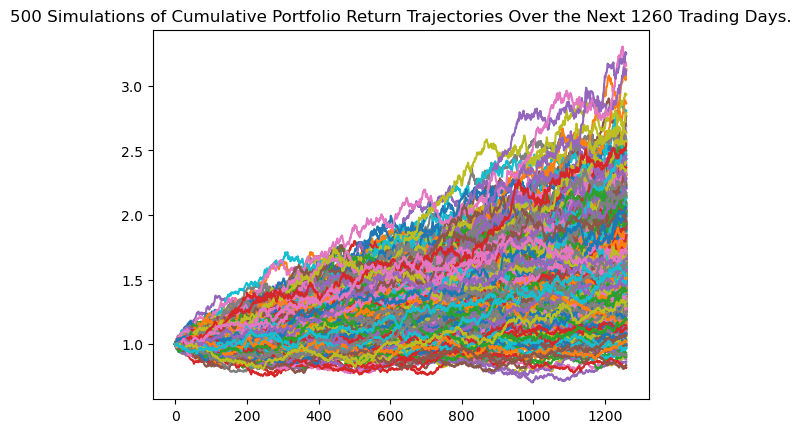

In [108]:
# Plot simulation outcomes
line_plot = MC_60_40_dist.plot_simulation()


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

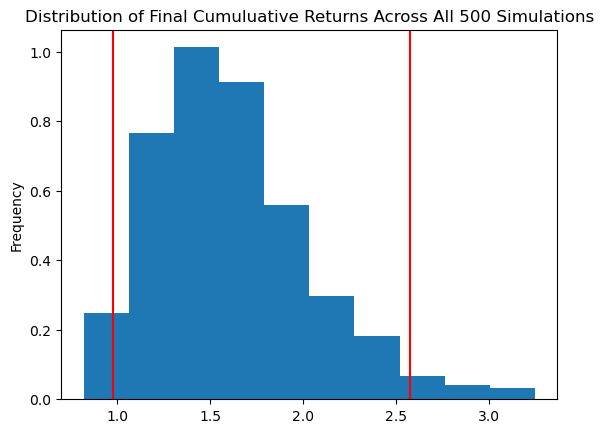

In [109]:
# Plot probability distribution and confidence intervals
MC_60_40_dist.plot_distribution()


In [110]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_60_40_dist.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              1.613322
std               0.424810
min               0.819185
25%               1.311340
50%               1.556099
75%               1.856673
max               3.249216
95% CI Lower      0.977682
95% CI Upper      2.578585
Name: 1260, dtype: float64


In [111]:
# Set initial investment
initial_investment = 50000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $50,000
ci_lower_five = round(tbl[8]*initial_investment,2)
ci_upper_five = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $50000 in the portfolio over the next 5 years will end within in the range of $48884.11 and $128929.26


### Ten Years Retirement Option

In [112]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_60_40_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.40,0.60],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [113]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_60_40_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993147,1.004197,0.987411,1.002931,0.995585,0.990710,1.000236,0.994933,1.012666,0.991698,...,0.997740,0.995257,1.007803,1.003139,1.006811,1.002869,1.001949,0.997826,1.014318,1.002973
2,0.991450,0.998218,0.985965,1.001920,0.982226,0.988973,0.990082,0.991082,1.017579,0.984936,...,0.992402,0.996074,1.018163,1.001921,1.011596,0.992352,1.002577,0.997344,1.000761,1.000205
3,0.990279,1.003366,0.979428,1.007288,0.982977,0.998063,0.996803,0.985264,1.022010,0.988224,...,0.984690,1.003358,1.027622,1.011555,1.008580,0.988865,0.989525,0.994964,1.003074,1.004595
4,0.986973,0.999785,0.984614,1.003311,0.989220,0.991362,1.004524,0.981803,1.017625,0.979521,...,0.985175,1.002311,1.035660,1.011415,1.006894,0.986911,0.989312,0.996892,1.005481,1.010926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.751179,3.156720,3.353396,2.615899,2.691228,2.243148,1.639413,2.063412,2.616741,1.056570,...,3.300088,1.405559,1.960629,4.424547,1.509742,2.373039,2.355417,2.765449,3.056823,1.645157
2517,4.826615,3.166210,3.335407,2.624213,2.679569,2.255105,1.628812,2.095090,2.656756,1.060313,...,3.314320,1.396475,1.991100,4.438807,1.529495,2.374974,2.351368,2.785662,3.054008,1.648082
2518,4.834811,3.169654,3.335328,2.635472,2.686106,2.250555,1.654651,2.095362,2.637635,1.053222,...,3.300789,1.393530,2.014969,4.476651,1.532131,2.386472,2.320588,2.815069,3.073733,1.619138
2519,4.905141,3.152779,3.364186,2.626278,2.662011,2.253978,1.642308,2.113230,2.646922,1.061942,...,3.336407,1.377198,2.001778,4.481193,1.506109,2.369389,2.323999,2.820575,3.062136,1.620893


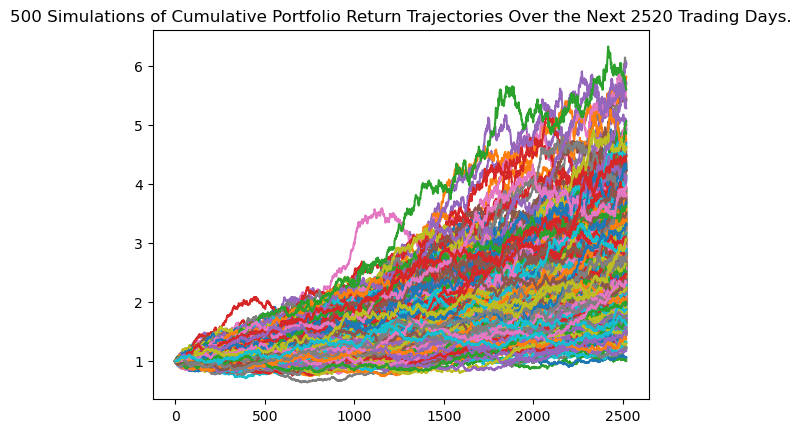

In [114]:
# Plot simulation outcomes
line_plot = MC_60_40_dist.plot_simulation()


<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

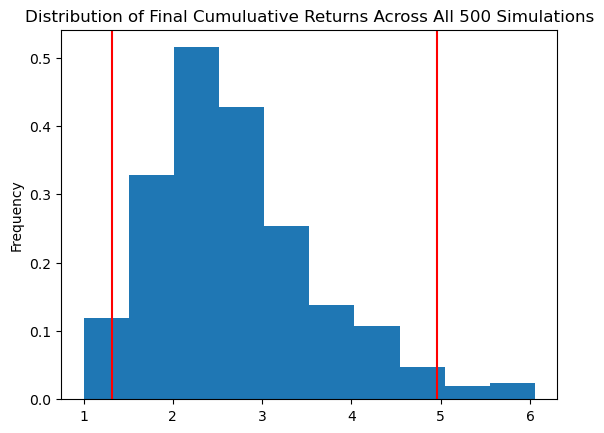

In [115]:
# Plot probability distribution and confidence intervals
MC_60_40_dist.plot_distribution()

In [116]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_60_40_dist.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              2.703678
std               0.926321
min               1.004146
25%               2.060750
50%               2.566357
75%               3.237686
max               6.053132
95% CI Lower      1.321879
95% CI Upper      4.960245
Name: 2520, dtype: float64


In [117]:
# Set initial investment
initial_investment = 40000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $40,000
ci_lower_ten = round(tbl[8]*initial_investment,2)
ci_upper_ten = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $40000 in the portfolio over the next 5 years will end within in the range of $52875.16 and $198409.79
